# Shampoo Sales Tutorial
Features on Jason Brownlee's *Machine Learning Mastery* blog [here](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# Silence TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf

In [3]:
# Import statements
# from __future__ import absolute_import
from pandas import DataFrame, Series, concat, read_csv, datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM
from keras.callbacks import History
from math import sqrt
from matplotlib import pyplot
import numpy
import pickle
import keras

Using TensorFlow backend.


In [4]:
# Data parser
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [5]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [7]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [9]:
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [10]:
# Load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [11]:
# Load scaler object
scaler = joblib.load('lstm_scaler.pkl')

In [12]:
# Load train and test dataframes
train = numpy.genfromtxt('train_df.csv', delimiter=',')
test = numpy.genfromtxt('test_df.csv', delimiter=',')
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)
raw_values = read_csv('shampoo_sales_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser).values

In [13]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(loaded_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=343.666719, Expected=339.700000
Month=2, Predicted=444.846595, Expected=440.400000
Month=3, Predicted=319.331821, Expected=315.900000
Month=4, Predicted=492.349419, Expected=439.300000
Month=5, Predicted=404.829111, Expected=401.300000
Month=6, Predicted=457.631336, Expected=437.400000
Month=7, Predicted=578.937028, Expected=575.500000
Month=8, Predicted=410.983959, Expected=407.600000
Month=9, Predicted=726.637727, Expected=682.000000
Month=10, Predicted=478.744519, Expected=475.300000
Month=11, Predicted=626.482994, Expected=581.300000
Month=12, Predicted=650.340646, Expected=646.900000


In [14]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.773


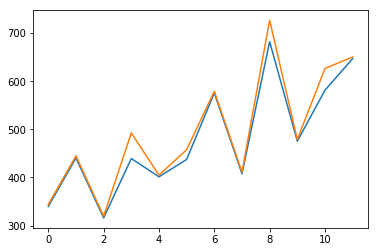

In [15]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

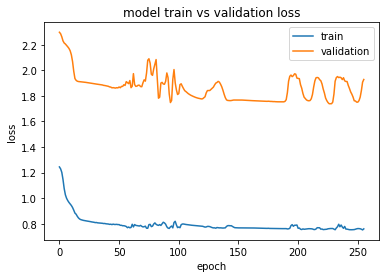

In [16]:
# Evaluate underfitting/overfitting
hist = pickle.load( open( "model_history.pkl", "rb" ) )
pyplot.plot(hist['loss'])
pyplot.plot(hist['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [17]:
%notify -m 'Notebook has finished running.'

<IPython.core.display.Javascript object>